# Information

## CC4_C5_min_mrg

This code uses:
+ Cleaner_Centroid with all 4 points
+ Then uses the centroid to compare distance between ['Client_Mouth', 'Client_S1', 'Client_S2', 'Client_Tail', 'Client_TailTip'] points, and calculates the distance.
+ I have a margin of 30 frames, where if it detects joins both

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy import stats  # For mode calculation

In [2]:
def detect_interactions(distances, min_consecutive=60, threshold=250, margin=30):
    """
    Detect interactions in a sequence of distances.

    Parameters:
        distances (list or numpy array): A sequence of distances.
        min_consecutive (int): Minimum consecutive frames required for an interaction.
        threshold (float): Threshold value to determine an interaction.
        margin (int): Number of frames where the rules don't apply and gaps can be merged.

    Returns:
        List of tuples where each tuple represents an interaction (start_frame, end_frame).
    """
    interactions = []
    current_start = None
    last_interaction_end = None  # Keep track of the end frame of the last interaction

    for i, distance in enumerate(distances):
        if distance < threshold:
            if current_start is None:
                current_start = i
        else:
            if current_start is not None:
                if i - current_start >= min_consecutive:
                    # Check if there is a margin to merge nearby interactions
                    if last_interaction_end is not None and current_start - last_interaction_end <= margin:
                        interactions[-1] = (interactions[-1][0], i - 1)
                    else:
                        interactions.append((current_start, i - 1))
                    last_interaction_end = i - 1
                current_start = None

    # Check if an interaction is ongoing at the end of the sequence
    if current_start is not None and len(distances) - current_start >= min_consecutive:
        interactions.append((current_start, len(distances) - 1))

    return interactions

In [3]:
directory = r"C:\Users\raulo\Desktop\ze_vids\phase_3\Tracks+Label_Top&Bot"
files = os.listdir(directory)

result_dataframes = {}

for file in files:
    df = pd.read_csv(os.path.join(directory, file))
    
    df["Behavior"].replace({"TS": "interaction", "jolts": "interaction"}, inplace=True)
    # Create a new DataFrame to store the results
    new_df = pd.DataFrame()

    # Add relevant data to the new DataFrame
    new_df["Behavior"] = df['Behavior']

    new_df['Client_Mouth_X_top'] = df['Client_Mouth']
    new_df['Client_Mouth_Y_top'] = df['Client_Mouth.1']
    new_df['Client_Mouth_Z_front']= df['Client_Mouth_Front.1']

    new_df['Client_S1_X_top'] = df['Client_Spine_1']
    new_df['Client_S1_Y_top'] = df['Client_Spine_1.1']
    new_df['Client_S1_Z_front']= df['Client_Spine_head_Front.1']

    new_df['Client_S2_X_top'] = df['Client_Spine_2']
    new_df['Client_S2_Y_top'] = df['Client_Spine_2.1']
    new_df['Client_S2_Z_front']= df['Client_Spine_mid_Front.1']

    new_df['Client_Tail_X_top'] = df['Client_Tail']
    new_df['Client_Tail_Y_top'] = df['Client_Tail.1']
    new_df['Client_Tail_Z_front']= df['Client_Tail_Front.1']
    
    new_df['Client_TailTip_X_top'] = df['Client_TailTip']
    new_df['Client_TailTip_Y_top'] = df['Client_TailTip.1']
    new_df['Client_TailTip_Z_front']= df['Client_Tail_Top_Front.1']

    
    
    new_df['Cleaner_Mouth_X_top'] = df['Cleaner_Mouth']
    new_df['Cleaner_Mouth_Y_top'] = df['Cleaner_Mouth.1']
    new_df['Cleaner_Mouth_Z_front']= df['Cleaner_Mouth_Front.1']

    new_df['Cleaner_Spine1_X_top'] = df['Cleaner_Spine1']
    new_df['Cleaner_Spine1_Y_top'] = df['Cleaner_Spine1.1']
    new_df['Cleaner_Spine1_Z_front']= df['Cleaner_Spine1_Front.1']

    new_df['Cleaner_Spine2_X_top'] = df['Cleaner_Spine2']
    new_df['Cleaner_Spine2_Y_top'] = df['Cleaner_Spine2.1']
    new_df['Cleaner_Spine2_Z_front']= df['Cleaner_Spine2_Front.1']

    new_df['Cleaner_Tail_X_top'] = df['Cleaner_Tail']
    new_df['Cleaner_Tail_Y_top'] = df['Cleaner_Tail.1']
    new_df['Cleaner_Tail_Z_front']= df['Cleaner_Tail_Front.1']
    

    new_df["Frame"] = df['Frame']
    
    # Create a new column in new_df to store the centroid of the cleaner fish for each row
    new_df['Cleaner_Centroid_X'] = new_df[['Cleaner_Mouth_X_top', 'Cleaner_Spine1_X_top', 'Cleaner_Spine2_X_top', 'Cleaner_Tail_X_top']].mean(axis=1)
    new_df['Cleaner_Centroid_Y'] = new_df[['Cleaner_Mouth_Y_top', 'Cleaner_Spine1_Y_top', 'Cleaner_Spine2_Y_top', 'Cleaner_Tail_Y_top']].mean(axis=1)
    new_df['Cleaner_Centroid_Z'] = new_df[['Cleaner_Mouth_Z_front', 'Cleaner_Spine1_Z_front', 'Cleaner_Spine2_Z_front', 'Cleaner_Tail_Z_front']].mean(axis=1)

    # Initialize a column to store the smallest distance for each row
    new_df['Min_Distance'] = np.inf  # Initialize with infinity

    # Loop through client points and calculate distance, updating 'Min_Distance' if a smaller distance is found
    for client_point in ['Client_Mouth', 'Client_S1', 'Client_S2', 'Client_Tail', 'Client_TailTip']:
        client_x = new_df[f'{client_point}_X_top']
        client_y = new_df[f'{client_point}_Y_top']
        client_z = new_df[f'{client_point}_Z_front']

        distance = np.sqrt(
            (client_x - new_df['Cleaner_Centroid_X'])**2 +
            (client_y - new_df['Cleaner_Centroid_Y'])**2 +
            (client_z - new_df['Cleaner_Centroid_Z'])**2
        )

        new_df['Min_Distance'] = np.minimum(new_df['Min_Distance'], distance)
    
    new_df["Interaction_Predictions"] = "background"  # Initialization of predictions

    result_dataframes[file.split("_")[0]] = new_df

## Histograms

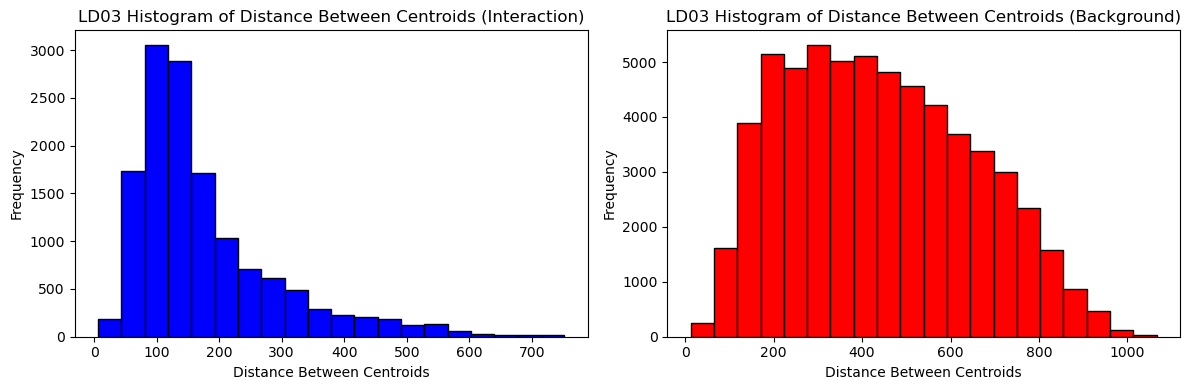

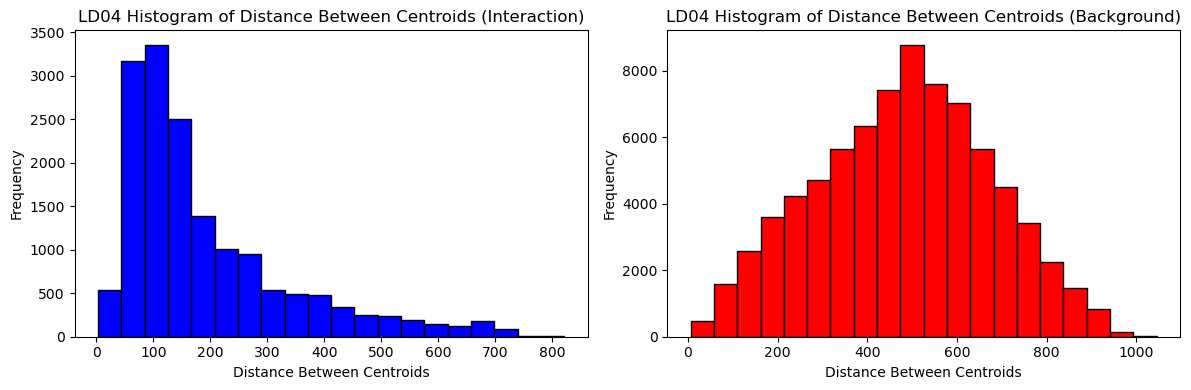

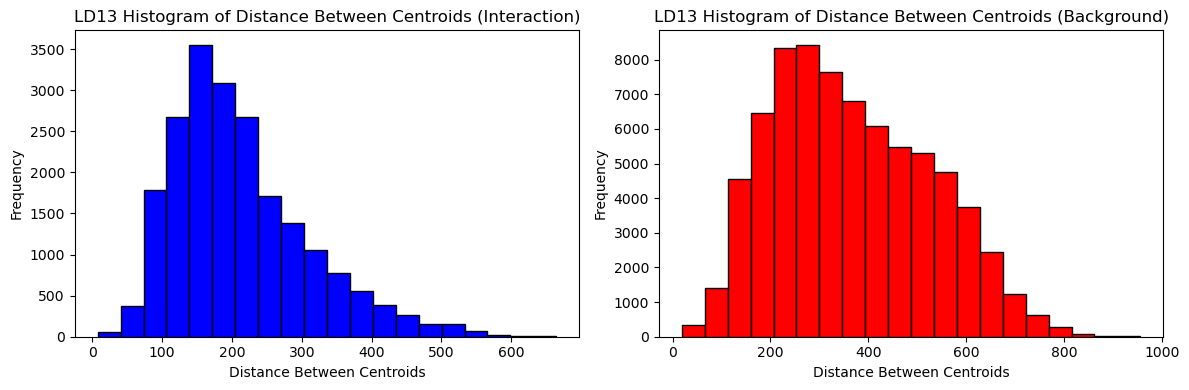

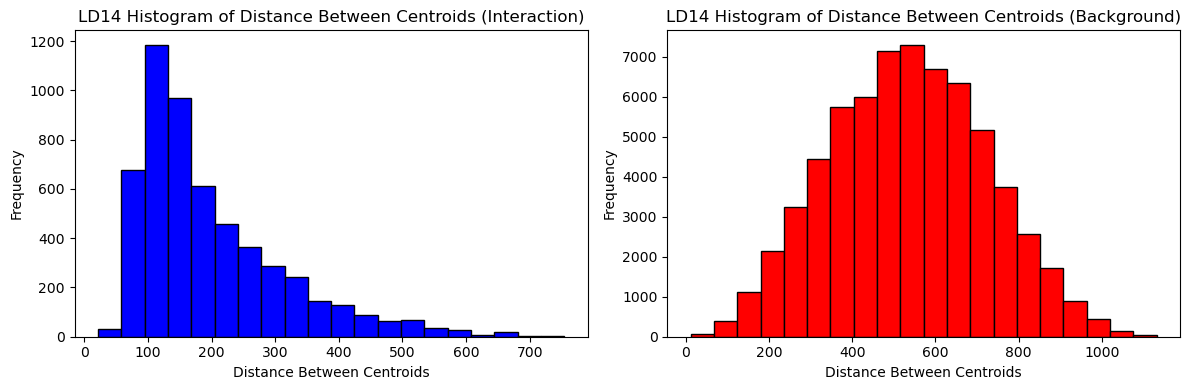

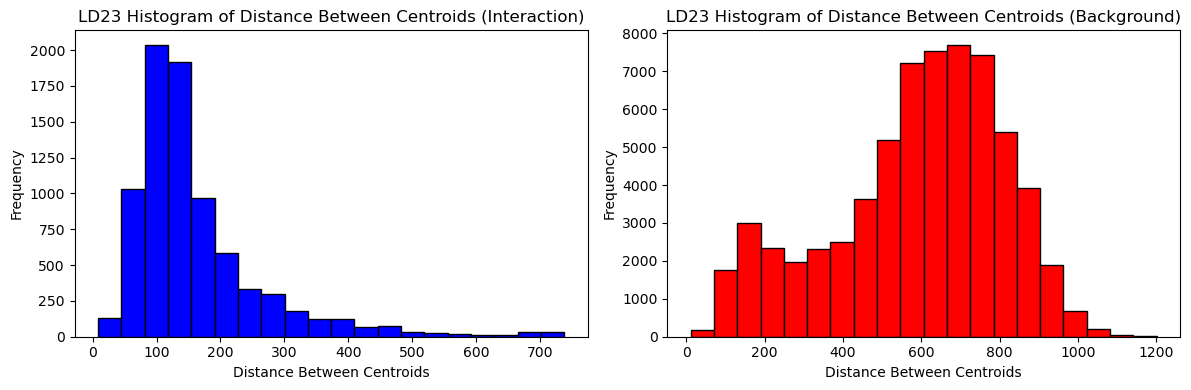

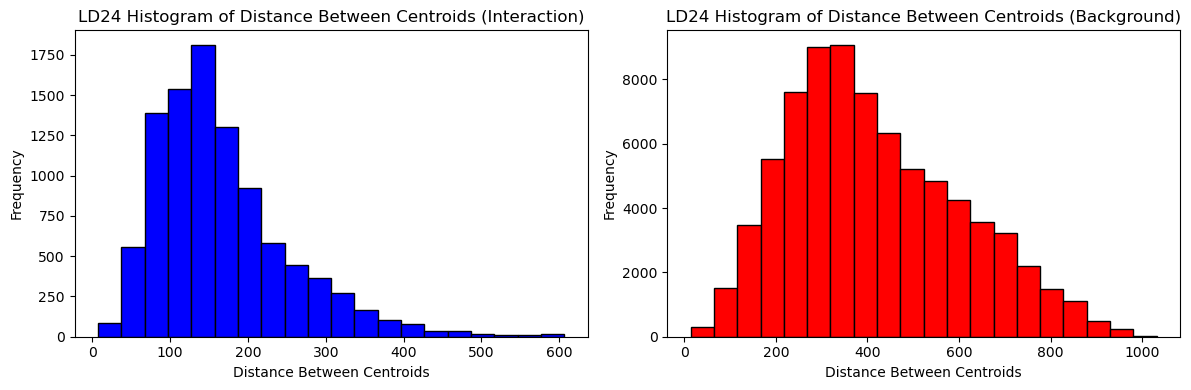

In [4]:
for data_frame in result_dataframes:
    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot the first histogram (interaction)
    ax1.hist(result_dataframes[data_frame][result_dataframes[data_frame]['Behavior'] == 'interaction']['Min_Distance'], bins=20, edgecolor='black', color='blue')
    ax1.set_xlabel('Distance Between Centroids')
    ax1.set_ylabel('Frequency')
    ax1.set_title(f'{data_frame} Histogram of Distance Between Centroids (Interaction)')

    # Plot the second histogram (non-interaction)
    ax2.hist(result_dataframes[data_frame][result_dataframes[data_frame]['Behavior'] == 'Background']['Min_Distance'], bins=20, edgecolor='black', color='red')
    ax2.set_xlabel('Distance Between Centroids')
    ax2.set_ylabel('Frequency')
    ax2.set_title(f'{data_frame} Histogram of Distance Between Centroids (Background)')

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

In [5]:
# Create a dictionary to store summary values for each DataFrame
summary_values = {}

for data_frame in result_dataframes:
    total_frames = 0
    correctly_detected_event = 0
    total = 0
    correctly_frame_count = 0

    interactions = detect_interactions(result_dataframes[data_frame]["Min_Distance"])

    for interaction in interactions:

        start_frame, end_frame = interaction

        if end_frame - start_frame + 1 >= 15:
            total += 1  # Increment the total count for eligible interactions
            total_frames += end_frame - start_frame + 1
            selected_data = result_dataframes[data_frame].loc[start_frame:end_frame, "Behavior"]
            mode_value = stats.mode(selected_data).mode[0]

            if mode_value == "interaction" or mode_value == "TS":
                correctly_detected_event +=1
                correctly_frame_count += end_frame - start_frame + 1

            # Store the prediction in the new column
            result_dataframes[data_frame].loc[start_frame:end_frame, "Interaction_Predictions"] = mode_value
                  
            # Store the summary values in the summary_values dictionary
            summary_values[data_frame] = {
            "total_frames": total_frames,
            "correctly_detected_event": correctly_detected_event,
            "total": total,
            "correctly_frame_count": correctly_frame_count
            }
            
#             if total == 1:
#                 print(f"\nData from: {data_frame}")            
#             print(f"Interaction detected from frame {start_frame} to {end_frame} (Duration: {end_frame - start_frame + 1} frames) with a true Behavior of {mode_value}")

C:\Users\raulo\AppData\Local\Temp\ipykernel_11564\828851113.py:20: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_value = stats.mode(selected_data).mode[0]
C:\Users\raulo\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "
C:\Users\raulo\AppData\Local\Temp\ipykernel_11564\828851113.py:20: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see 

In [6]:
# Define a list of threshold and min_consecutive values to test
threshold_values = [150, 175, 200, 225, 250]  # Add more values if needed
min_consecutive_values = [30, 45, 60]  # Add more values if needed


for threshold in threshold_values:
    for min_consecutive in min_consecutive_values:

        summary_values = {}

        for data_frame_name, data_frame in result_dataframes.items():
            # Initialize variables to keep track of the current group
            current_group = None
            interaction_count = 0

            # Iterate through the "Behavior" column
            for behavior in data_frame["Behavior"]:
                if behavior == "interaction":
                    if current_group != "interaction":
                        # Start of a new interaction group
                        interaction_count += 1
                        current_group = "interaction"
                else:
                    current_group = None  # Reset the group if behavior is not "interaction"

            summary_values[data_frame_name] = {"true interaction count": interaction_count}

            # Reset the other summary values to zero to avoid overwriting
            total_frames = 0
            correctly_detected_event = 0
            total = 0
            correctly_frame_count = 0

            interactions = detect_interactions(result_dataframes[data_frame_name]["Min_Distance"], min_consecutive, threshold)

            for interaction in interactions:
                start_frame, end_frame = interaction

                if end_frame - start_frame + 1 >= 15:
                    total += 1  # Increment the total count for eligible interactions
                    total_frames += end_frame - start_frame + 1
                    selected_data = result_dataframes[data_frame_name].loc[start_frame:end_frame, "Behavior"]
                    #mode_value = stats.mode(selected_data).mode[0]
                    mode_value = selected_data.mode().iloc[0]
                    
                    if mode_value == "interaction" or mode_value == "TS":
                        correctly_detected_event += 1
                        correctly_frame_count += end_frame - start_frame + 1

                    # Store the prediction in the new column
                    result_dataframes[data_frame_name].loc[start_frame:end_frame, "Interaction_Predictions"] = mode_value

                # Update the existing summary values in the summary_values dictionary
                summary_values[data_frame_name].update({
                "total_frames": total_frames,
                "correctly_detected_event": correctly_detected_event,
                "total": total,
                "correctly_frame_count": correctly_frame_count
                })

        #         if total == 1:
        #             print(f"\nData from: {data_frame_name}")
        #         print(f"Interaction detected from frame {start_frame} to {end_frame} (Duration: {end_frame - start_frame + 1} frames) with a true Behavior of {mode_value}")

        for data_frame, summary in summary_values.items():
            true_interaction_count = summary['true interaction count']
            total_frames = summary['total_frames']
            correctly_frame_count = summary['correctly_frame_count']
            total_detected_events = summary['total']
            correctly_detected_events = summary['correctly_detected_event']

            accuracy = (correctly_frame_count / total_frames) * 100

            print(f"Data from: {data_frame} with threshold of: {threshold} and min_consecutives of: {min_consecutive}")
            print(f"This data has {true_interaction_count} true events")
            print(f"There were {correctly_frame_count} frames correctly classified, out of a total of {total_frames} frames classified as interaction.")
            print(f"This results in an accuracy of {accuracy:.2f}%.")
            print(f"There were a total of {correctly_detected_events} events detected correctly, out of {total_detected_events} total events detected. ({correctly_detected_events/total_detected_events *100:.2f}%)")
            print(f"There was {correctly_detected_events/true_interaction_count * 100:.2f}% events detected")
            print("")

Data from: LD03 with threshold of: 150 and min_consecutives of: 30
This data has 69 true events
There were 7080 frames correctly classified, out of a total of 8818 frames classified as interaction.
This results in an accuracy of 80.29%.
There were a total of 60 events detected correctly, out of 89 total events detected. (67.42%)
There was 86.96% events detected

Data from: LD04 with threshold of: 150 and min_consecutives of: 30
This data has 63 true events
There were 8605 frames correctly classified, out of a total of 10196 frames classified as interaction.
This results in an accuracy of 84.40%.
There were a total of 67 events detected correctly, out of 98 total events detected. (68.37%)
There was 106.35% events detected

Data from: LD13 with threshold of: 150 and min_consecutives of: 30
This data has 81 true events
There were 4483 frames correctly classified, out of a total of 6505 frames classified as interaction.
This results in an accuracy of 68.92%.
There were a total of 67 events

Data from: LD03 with threshold of: 175 and min_consecutives of: 60
This data has 69 true events
There were 8092 frames correctly classified, out of a total of 9342 frames classified as interaction.
This results in an accuracy of 86.62%.
There were a total of 51 events detected correctly, out of 64 total events detected. (79.69%)
There was 73.91% events detected

Data from: LD04 with threshold of: 175 and min_consecutives of: 60
This data has 63 true events
There were 8941 frames correctly classified, out of a total of 10331 frames classified as interaction.
This results in an accuracy of 86.55%.
There were a total of 53 events detected correctly, out of 69 total events detected. (76.81%)
There was 84.13% events detected

Data from: LD13 with threshold of: 175 and min_consecutives of: 60
This data has 81 true events
There were 4749 frames correctly classified, out of a total of 6534 frames classified as interaction.
This results in an accuracy of 72.68%.
There were a total of 43 events 

Data from: LD03 with threshold of: 225 and min_consecutives of: 30
This data has 69 true events
There were 11288 frames correctly classified, out of a total of 19314 frames classified as interaction.
This results in an accuracy of 58.44%.
There were a total of 66 events detected correctly, out of 168 total events detected. (39.29%)
There was 95.65% events detected

Data from: LD04 with threshold of: 225 and min_consecutives of: 30
This data has 63 true events
There were 12143 frames correctly classified, out of a total of 17593 frames classified as interaction.
This results in an accuracy of 69.02%.
There were a total of 66 events detected correctly, out of 155 total events detected. (42.58%)
There was 104.76% events detected

Data from: LD13 with threshold of: 225 and min_consecutives of: 30
This data has 81 true events
There were 13285 frames correctly classified, out of a total of 26510 frames classified as interaction.
This results in an accuracy of 50.11%.
There were a total of 93

Data from: LD03 with threshold of: 250 and min_consecutives of: 45
This data has 69 true events
There were 11893 frames correctly classified, out of a total of 20183 frames classified as interaction.
This results in an accuracy of 58.93%.
There were a total of 62 events detected correctly, out of 141 total events detected. (43.97%)
There was 89.86% events detected

Data from: LD04 with threshold of: 250 and min_consecutives of: 45
This data has 63 true events
There were 12575 frames correctly classified, out of a total of 17521 frames classified as interaction.
This results in an accuracy of 71.77%.
There were a total of 65 events detected correctly, out of 125 total events detected. (52.00%)
There was 103.17% events detected

Data from: LD13 with threshold of: 250 and min_consecutives of: 45
This data has 81 true events
There were 14309 frames correctly classified, out of a total of 29422 frames classified as interaction.
This results in an accuracy of 48.63%.
There were a total of 86

In [7]:
interaction_counts = {}  # Create a dictionary to store interaction counts for each DataFrame

for data_frame_name, data_frame in result_dataframes.items():
    # Initialize variables to keep track of the current group
    current_group = None
    interaction_count = 0

    # Iterate through the "Behavior" column
    for behavior in data_frame["Behavior"]:
        if behavior == "interaction":
            if current_group != "interaction":
                # Start of a new interaction group
                interaction_count += 1
                current_group = "interaction"
        else:
            current_group = None  # Reset the group if behavior is not "interaction"

    interaction_counts[data_frame_name] = interaction_count

interaction_counts_60 = {}  # Create a dictionary to store interaction counts for each DataFrame

for data_frame_name, data_frame in result_dataframes.items():
    # Initialize variables to keep track of the current group
    current_group = None
    interaction_count = 0
    current_group_count = 0

    # Iterate through the "Behavior" column
    for behavior in data_frame["Behavior"]:
        if behavior == "interaction":
            if current_group != "interaction":
                # Start of a new interaction group
                current_group_count = 1
                current_group = "interaction"
            else:
                current_group_count += 1
        else:
            if current_group_count >= 45:
                interaction_count += 1
            current_group = None  # Reset the group if behavior is not "interaction"
            current_group_count = 0

    # Check if the last group, if any, was an "interaction" group and met the condition
    if current_group_count > 90:
        interaction_count += 1

    interaction_counts_60[data_frame_name] = interaction_count
    
print("all",interaction_counts)
print("+60",interaction_counts_60)

all {'LD03': 69, 'LD04': 63, 'LD13': 81, 'LD14': 34, 'LD23': 30, 'LD24': 50}
+60 {'LD03': 68, 'LD04': 59, 'LD13': 74, 'LD14': 32, 'LD23': 29, 'LD24': 44}


## Predicted Correct Events

In [8]:
# Define a list of threshold and min_consecutive values to test
threshold_values = [150, 175, 200, 225, 250]  # Add more values if needed
min_consecutive_values = [30, 45, 60]  # Add more values if needed

# Iterate through all data frames
for data_frame_name, data_frame in result_dataframes.items():
    # Initialize a nested dictionary to store correctly detected events
    correctly_detected_events = {}

    # Loop through threshold and min_consecutive values
    for threshold in threshold_values:
        correctly_detected_events[threshold] = {}  # Initialize inner dictionary
        for min_consecutive in min_consecutive_values:
            summary_values = {}

            # Initialize variables to keep track of the current group
            current_group = None
            interaction_count = 0

            # Iterate through the "Behavior" column
            for behavior in data_frame["Behavior"]:
                if behavior == "interaction":
                    if current_group != "interaction":
                        # Start of a new interaction group
                        interaction_count += 1
                        current_group = "interaction"
                else:
                    current_group = None  # Reset the group if behavior is not "interaction"

            summary_values[data_frame_name] = {"true interaction count": interaction_count}

            # Reset the other summary values to zero to avoid overwriting
            total_frames = 0
            correctly_detected_event = 0
            total = 0
            correctly_frame_count = 0

            interactions = detect_interactions(data_frame["Min_Distance"], min_consecutive, threshold)

            for interaction in interactions:
                start_frame, end_frame = interaction

                if end_frame - start_frame + 1 >= 15:
                    total += 1  # Increment the total count for eligible interactions
                    total_frames += end_frame - start_frame + 1
                    selected_data = data_frame.loc[start_frame:end_frame, "Behavior"]
                    mode_value = selected_data.mode().iloc[0]

                    if mode_value == "interaction" or mode_value == "TS":
                        correctly_detected_event += 1
                        correctly_frame_count += end_frame - start_frame + 1

                    # Store the prediction in the new column
                    data_frame.loc[start_frame:end_frame, "Interaction_Predictions"] = mode_value

                # Update the existing summary values in the summary_values dictionary
                summary_values[data_frame_name].update({
                    "total_frames": total_frames,
                    "correctly_detected_event": correctly_detected_event,
                    "total": total,
                    "correctly_frame_count": correctly_frame_count
                })

            correctly_detected_events[threshold][min_consecutive] = correctly_detected_event
    print(f"Data Frame: {data_frame_name}. With a total of: {interaction_count} events")  # Add a header for the data frame
    
    # Now, display the table for the current data frame
    print("\t" + "\t".join(map(str, threshold_values)))  # Print column headers
    for min_consecutive in min_consecutive_values:
        row_values = [str(min_consecutive)]  # Start the row with min_consecutive value
        for threshold in threshold_values:
            cell_value = correctly_detected_events[threshold][min_consecutive]
            row_values.append(str(cell_value))
        print("\t".join(row_values))

    # Add a line to separate data frames
    print("-" * 60)

Data Frame: LD03. With a total of: 69 events
	150	175	200	225	250
30	60	60	64	66	64
45	53	58	57	62	62
60	35	51	52	58	57
------------------------------------------------------------
Data Frame: LD04. With a total of: 63 events
	150	175	200	225	250
30	67	67	68	66	68
45	56	65	64	64	65
60	47	53	55	59	63
------------------------------------------------------------
Data Frame: LD13. With a total of: 81 events
	150	175	200	225	250
30	67	92	93	93	96
45	45	64	78	83	86
60	26	43	69	66	78
------------------------------------------------------------
Data Frame: LD14. With a total of: 34 events
	150	175	200	225	250
30	22	28	30	33	33
45	18	20	25	28	29
60	11	17	22	23	24
------------------------------------------------------------
Data Frame: LD23. With a total of: 30 events
	150	175	200	225	250
30	32	29	28	25	25
45	27	28	27	24	23
60	23	25	24	22	23
------------------------------------------------------------
Data Frame: LD24. With a total of: 50 events
	150	175	200	225	250
30	45	52	49	48	45
45	34	42	43

## Number of wrong Events wrongly detected

In [9]:
# Define a list of threshold and min_consecutive values to test
threshold_values = [150, 175, 200, 225, 250]  # Add more values if needed
min_consecutive_values = [30, 45, 60]  # Add more values if needed

# Iterate through all data frames
for data_frame_name, data_frame in result_dataframes.items():
    print(f"Data Frame: {data_frame_name}")  # Add a header for the data frame

    # Initialize a nested dictionary to store correctly detected events
    correctly_detected_events = {}

    # Loop through threshold and min_consecutive values
    for threshold in threshold_values:
        correctly_detected_events[threshold] = {}  # Initialize inner dictionary
        for min_consecutive in min_consecutive_values:
            summary_values = {}

            # Initialize variables to keep track of the current group
            current_group = None
            interaction_count = 0

            # Iterate through the "Behavior" column
            for behavior in data_frame["Behavior"]:
                if behavior == "interaction":
                    if current_group != "interaction":
                        # Start of a new interaction group
                        interaction_count += 1
                        current_group = "interaction"
                else:
                    current_group = None  # Reset the group if behavior is not "interaction"

            summary_values[data_frame_name] = {"true interaction count": interaction_count}

            # Reset the other summary values to zero to avoid overwriting
            total_frames = 0
            correctly_detected_event = 0
            total = 0
            correctly_frame_count = 0
            wrongly_detected_event = 0
            wrongly_detected_frames = 0

            interactions = detect_interactions(data_frame["Min_Distance"], min_consecutive, threshold)

            for interaction in interactions:
                start_frame, end_frame = interaction

                if end_frame - start_frame + 1 >= 15:
                    total += 1  # Increment the total count for eligible interactions
                    total_frames += end_frame - start_frame + 1
                    selected_data = data_frame.loc[start_frame:end_frame, "Behavior"]
                    mode_value = selected_data.mode().iloc[0]

                    if mode_value == "interaction" or mode_value == "TS":
                        correctly_detected_event += 1
                        correctly_frame_count += end_frame - start_frame + 1
                        
                    else:
                        wrongly_detected_event += 1
                        wrongly_detected_frames += end_frame - start_frame + 1
                        
                    # Store the prediction in the new column
                    data_frame.loc[start_frame:end_frame, "Interaction_Predictions"] = mode_value

                # Update the existing summary values in the summary_values dictionary
                summary_values[data_frame_name].update({
                    "total_frames": total_frames,
                    "correctly_detected_event": correctly_detected_event,
                    "total_detected_events": total,
                    "correctly_frame_count": correctly_frame_count,
                    "wrongly_detected_event": wrongly_detected_event,
                    "wrongly_detected_frames": wrongly_detected_frames
                })

            correctly_detected_events[threshold][min_consecutive] = summary_values[data_frame_name]["wrongly_detected_event"]  # Calculate and store the ratio

    # Now, display the table for the current data frame
    print("\t" + "\t".join(map(str, threshold_values)))  # Print column headers
    for min_consecutive in min_consecutive_values:
        row_values = [str(min_consecutive)]  # Start the row with min_consecutive value
        for threshold in threshold_values:
            cell_value = correctly_detected_events[threshold][min_consecutive]
            row_values.append(f"{cell_value}")  # Format as percentage
        print("\t".join(row_values))

    # Add a line to separate data frames
    print("-" * 60)

Data Frame: LD03
	150	175	200	225	250
30	29	49	78	102	124
45	14	24	38	60	79
60	7	13	25	35	55
------------------------------------------------------------
Data Frame: LD04
	150	175	200	225	250
30	31	44	65	89	122
45	17	24	33	45	60
60	13	16	22	26	36
------------------------------------------------------------
Data Frame: LD13
	150	175	200	225	250
30	46	103	150	177	200
45	17	50	82	120	140
60	6	22	49	73	99
------------------------------------------------------------
Data Frame: LD14
	150	175	200	225	250
30	1	5	14	24	38
45	1	1	2	8	14
60	1	1	0	0	3
------------------------------------------------------------
Data Frame: LD23
	150	175	200	225	250
30	18	20	19	21	27
45	13	18	15	15	18
60	13	14	12	13	14
------------------------------------------------------------
Data Frame: LD24
	150	175	200	225	250
30	44	73	98	127	142
45	13	36	55	78	106
60	4	17	32	48	72
------------------------------------------------------------


## Number of correct frames

In [10]:
# Define a list of threshold and min_consecutive values to test
threshold_values = [150, 175, 200, 225, 250]  # Add more values if needed
min_consecutive_values = [30, 45, 60]  # Add more values if needed

# Iterate through all data frames
for data_frame_name, data_frame in result_dataframes.items():
    # Initialize a nested dictionary to store correctly detected frames
    correctly_detected_frames = {}

    # Loop through threshold and min_consecutive values
    for threshold in threshold_values:
        correctly_detected_frames[threshold] = {}  # Initialize inner dictionary
        for min_consecutive in min_consecutive_values:
            summary_values = {}

            # Initialize variables to keep track of the current group
            current_group = None
            interaction_count = 0

            # Iterate through the "Behavior" column
            for behavior in data_frame["Behavior"]:
                if behavior == "interaction":
                    if current_group != "interaction":
                        # Start of a new interaction group
                        interaction_count += 1
                        current_group = "interaction"
                else:
                    current_group = None  # Reset the group if behavior is not "interaction"

            summary_values[data_frame_name] = {"true interaction count": interaction_count}

            # Reset the other summary values to zero to avoid overwriting
            total_frames = 0
            correctly_detected_frames_count = 0  # Updated variable name
            total = 0
            correctly_frame_count = 0

            interactions = detect_interactions(data_frame["Min_Distance"], min_consecutive, threshold)

            for interaction in interactions:
                start_frame, end_frame = interaction

                if end_frame - start_frame + 1 >= 15:
                    total += 1  # Increment the total count for eligible interactions
                    total_frames += end_frame - start_frame + 1
                    selected_data = data_frame.loc[start_frame:end_frame, "Behavior"]
                    mode_value = selected_data.mode().iloc[0]

                    if mode_value == "interaction" or mode_value == "TS":
                        correctly_detected_frames_count += end_frame - start_frame + 1  # Updated variable name

                    # Store the prediction in the new column
                    data_frame.loc[start_frame:end_frame, "Interaction_Predictions"] = mode_value

                # Update the existing summary values in the summary_values dictionary
                summary_values[data_frame_name].update({
                    "total_frames": total_frames,
                    "correctly_detected_frames_count": correctly_detected_frames_count,  # Updated variable name
                    "total": total,
                    "correctly_frame_count": correctly_frame_count
                })

            correctly_detected_frames[threshold][min_consecutive] = correctly_detected_frames_count  # Updated variable name
    print(f"Data Frame: {data_frame_name}. With a total of: {data_frame['Behavior'].value_counts().get('interaction', 0)} frames")  # Add a header for the data frame

    # Now, display the table for the current data frame
    print("\t" + "\t".join(map(str, threshold_values)))  # Print column headers
    for min_consecutive in min_consecutive_values:
        row_values = [str(min_consecutive)]  # Start the row with min_consecutive value
        for threshold in threshold_values:
            cell_value = correctly_detected_frames[threshold][min_consecutive]  # Updated variable name
            row_values.append(str(cell_value))
        print("\t".join(row_values))

    # Add a line to separate data frames
    print("-" * 60)

Data Frame: LD03. With a total of: 13729 frames
	150	175	200	225	250
30	7080	9325	10810	11288	12415
45	6331	8724	10119	10867	11893
60	5112	8092	9623	11193	11284
------------------------------------------------------------
Data Frame: LD04. With a total of: 15986 frames
	150	175	200	225	250
30	8605	9967	10938	12143	13071
45	7521	9683	10714	11718	12575
60	6820	8941	9985	11229	12220
------------------------------------------------------------
Data Frame: LD13. With a total of: 20744 frames
	150	175	200	225	250
30	4483	7912	10789	13285	14911
45	3493	6245	9442	12651	14309
60	2471	4749	8419	11157	13975
------------------------------------------------------------
Data Frame: LD14. With a total of: 5423 frames
	150	175	200	225	250
30	2131	2843	3472	4145	4552
45	1890	2507	3216	3767	4300
60	1536	2281	2930	3314	3806
------------------------------------------------------------
Data Frame: LD23. With a total of: 8044 frames
	150	175	200	225	250
30	4958	5982	6677	6959	7338
45	4615	5665	6583	7071	726

## Number of wrong frames predicted

In [11]:
# Define a list of threshold and min_consecutive values to test
threshold_values = [150, 175, 200, 225, 250]  # Add more values if needed
min_consecutive_values = [30, 45, 60]  # Add more values if needed

# Iterate through all data frames
for data_frame_name, data_frame in result_dataframes.items():
    # Initialize a nested dictionary to store incorrectly detected frames
    incorrectly_detected_frames = {}

    # Loop through threshold and min_consecutive values
    for threshold in threshold_values:
        incorrectly_detected_frames[threshold] = {}  # Initialize inner dictionary
        for min_consecutive in min_consecutive_values:
            summary_values = {}

            # Initialize variables to keep track of the current group
            current_group = None
            interaction_count = 0

            # Iterate through the "Behavior" column
            for behavior in data_frame["Behavior"]:
                if behavior == "interaction":
                    if current_group != "interaction":
                        # Start of a new interaction group
                        interaction_count += 1
                        current_group = "interaction"
                else:
                    current_group = None  # Reset the group if behavior is not "interaction"

            summary_values[data_frame_name] = {"true interaction count": interaction_count}

            # Reset the other summary values to zero to avoid overwriting
            total_frames = 0
            correctly_detected_frames_count = 0
            incorrectly_detected_frames_count = 0  # Updated variable name
            total = 0
            correctly_frame_count = 0

            interactions = detect_interactions(data_frame["Min_Distance"], min_consecutive, threshold)

            for interaction in interactions:
                start_frame, end_frame = interaction

                if end_frame - start_frame + 1 >= 15:
                    total += 1  # Increment the total count for eligible interactions
                    total_frames += end_frame - start_frame + 1
                    selected_data = data_frame.loc[start_frame:end_frame, "Behavior"]
                    mode_value = selected_data.mode().iloc[0]

                    if mode_value == "interaction" or mode_value == "TS":
                        correctly_detected_frames_count += end_frame - start_frame + 1
                    else:
                        incorrectly_detected_frames_count += end_frame - start_frame + 1

                    # Store the prediction in the new column
                    data_frame.loc[start_frame:end_frame, "Interaction_Predictions"] = mode_value

                # Update the existing summary values in the summary_values dictionary
                summary_values[data_frame_name].update({
                    "total_frames": total_frames,
                    "correctly_detected_frames_count": correctly_detected_frames_count,
                    "incorrectly_detected_frames_count": incorrectly_detected_frames_count,  # Updated variable name
                    "total": total,
                    "correctly_frame_count": correctly_frame_count
                })

            incorrectly_detected_frames[threshold][min_consecutive] = incorrectly_detected_frames_count  # Updated variable name
    print(f"Data Frame: {data_frame_name}. With a total of: {data_frame['Behavior'].value_counts().get('interaction', 0)} frames")  # Add a header for the data frame

    # Now, display the table for the current data frame
    print("\t" + "\t".join(map(str, threshold_values)))  # Print column headers
    for min_consecutive in min_consecutive_values:
        row_values = [str(min_consecutive)]  # Start the row with min_consecutive value
        for threshold in threshold_values:
            cell_value = incorrectly_detected_frames[threshold][min_consecutive]  # Updated variable name
            row_values.append(str(cell_value))
        print("\t".join(row_values))

    # Add a line to separate data frames
    print("-" * 60)

Data Frame: LD03. With a total of: 13729 frames
	150	175	200	225	250
30	1738	3176	5034	8026	10223
45	971	2021	3455	6103	8290
60	615	1250	2740	3846	6923
------------------------------------------------------------
Data Frame: LD04. With a total of: 15986 frames
	150	175	200	225	250
30	1591	2627	3935	5450	7453
45	1268	1891	2700	3633	4946
60	984	1390	2148	2588	3655
------------------------------------------------------------
Data Frame: LD13. With a total of: 20744 frames
	150	175	200	225	250
30	2022	5453	9341	13225	17894
45	1011	3273	6490	10361	15113
60	448	1785	4670	7607	11897
------------------------------------------------------------
Data Frame: LD14. With a total of: 5423 frames
	150	175	200	225	250
30	60	218	534	998	1786
45	60	74	97	416	752
60	60	74	0	0	185
------------------------------------------------------------
Data Frame: LD23. With a total of: 8044 frames
	150	175	200	225	250
30	1842	3528	4298	5144	6279
45	1582	3256	3988	4687	5912
60	1582	2952	3764	4312	5431
---------------

#### Creates a dict with predicted | true labels for all dataframes with all param combinations

In [12]:
# Define a list of threshold and min_consecutive values to test
threshold_values = [150, 175, 200, 225, 250]
min_consecutive_values = [30, 45, 60]

# Initialize a dictionary to store results for each combination
results_dict = {}

# Iterate through all data frames
for data_frame_name, data_frame in result_dataframes.items():
    # Initialize a nested dictionary for the current data frame
    data_frame_results = {}

    # Loop through threshold and min_consecutive values
    for threshold in threshold_values:
        for min_consecutive in min_consecutive_values:
            interactions = detect_interactions(data_frame["Min_Distance"], min_consecutive, threshold)

            # Initialize an empty DataFrame to store "Behavior" and "Interaction_Predictions" columns
            selected_data = pd.DataFrame(columns=["Behavior", "Interaction_Predictions"])
            selected_data["Behavior"] = data_frame["Behavior"]
            selected_data["Interaction_Predictions"] = "background"

            for interaction in interactions:
                start_frame, end_frame = interaction

                if end_frame - start_frame + 1 >= 15:
                    selected_data.loc[start_frame:end_frame, "Interaction_Predictions"] = "interaction"

            # Store the selected data in the data frame results
            data_frame_results[(threshold, min_consecutive)] = selected_data

    # Store the data frame results in the overall results dictionary
    results_dict[data_frame_name] = data_frame_results

In [13]:
# Specify the folder where you want to save the CSV files
output_folder = r"C:\Users\raulo\Desktop\ze_vids\phase_3\results_dataframes\CleanerCentroid4_Client5_smaller_margin"

# Save the results to CSV files
for data_frame_name, data_frame_results in results_dict.items():
    for (threshold, min_consecutive), selected_data in data_frame_results.items():
        # Generate a filename based on the data frame name, threshold, and min_consecutive values
        filename = f"{data_frame_name}_threshold{threshold}_minc{min_consecutive}.csv"

        # Create the full path by joining the output folder and filename
        full_path = os.path.join(output_folder, filename)

        # Save the selected data to CSV
        selected_data.to_csv(full_path, index=False)